In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Resize(64),
        # transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),  # 3 for RGB channels
        # transforms.Normalize(mean=(0.0,), std=(0.5,)),  # 3 for RGB channels
    ]
)


def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


def save_reconstructs(
    encoder, decoder, x, epoch, nz=20, device="cuda", normalize=False
):
    with torch.no_grad():
        x = x.to(device)
        y = encoder(x)
        sample = decoder(y).cpu()
        if normalize:
            sample = denorm(sample)
            x = denorm(x)
        # save_image(x.view(x.shape[0], 3, 28, 28),
        save_image(x, "results/originals_" + str(epoch) + ".png")
        save_image(sample, "results/reconstructs_" + str(epoch) + ".png")


def save_random_reconstructs(model, nz, epoch, device="cuda", normalize=False,
        sampler=None):
    with torch.no_grad():
        if sampler == None:
            sample = torch.randn(64, nz).to(device)
        else:
            sample = sampler((64, )).to(device)
        sample = model(sample).cpu()
        if normalize:
            sample = denorm(sample)
        save_image(sample, "results/sample_" + str(epoch) + ".png")

def test(x, f=None):
    if f==None:
        return x
    else:
        return f(x)
test(10, lambda x: x*7 + 7)

77

In [7]:
# This is an attempt to reconstruct some of the networks and results from the
# original paper (Adversarial Autoencoders, Makhzani et. al)
import argparse
import os
import torch
import time
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
#import torch.distributions as D
from torch import distributions
from torchvision import models


def init_weights(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

class Net(nn.Module):
    def __init__(
        self,
        nin,
        nout,
        nh=3000,
        dropout=0,
        activation=nn.Identity(),
        unflatten=False,
        image_size=28,
        batchnorm=True,
    ):
        """
        nin, nout, nh are (self explanatory) the dimensions of the input,
        output, and the hidden layers.
        dropout should be a real value between 0 and 1.
        activation is the the activation function used on the output layer.
        If batcnorm=True, batch normalization is applied to the hidden layers,
        after activation.
        """
        super(Net, self).__init__()
        self.nin = nin
        self.nz = nout
        self.nh = nh
        self.unflatten = unflatten
        self.image_size = image_size
        self.dropout = 1.0 * dropout
        self.batchnorm = nn.Identity()
        if batchnorm:
            self.batchnorm = nn.BatchNorm1d(num_features=nh)
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=self.dropout),
            nn.Linear(nin, nh),
            nn.ReLU(),
            #nn.BatchNorm1d(num_features=nh),
            self.batchnorm,
            nn.Linear(nh, nh),
            nn.ReLU(),
            #nn.BatchNorm1d(num_features=nh),
            self.batchnorm,
            nn.Linear(nh, nout),
            activation,
        )

    def forward(self, input):
        output = self.main(input)
        if self.unflatten:
            output = nn.Unflatten(1, (1, self.image_size, self.image_size))(output)
        return output


In [3]:
def trainAE(E, D, optE, optD, data, device, criterion=nn.BCELoss()):
    E.train()
    D.train()
    optE.zero_grad()
    optD.zero_grad()
    x = data.to(device)
    z = E(x)
    recon = D(z)
    lossED = criterion(recon, x)
    lossED.backward()
    optD.step()
    optE.step()
    return lossED

def trainG(G, Dz, optG, data, device, criterion=nn.BCELoss()):
    batch_size = data.shape[0]
    Dz.eval()
    G.train()
    optG.zero_grad()
    labels_real = torch.ones(batch_size, 1).to(device)
    x = data.to(device)
    z = G(x)
    pred = Dz(z)
    lossG = criterion(pred, labels_real)
    lossG.backward()
    optG.step()
    return lossG

def trainDz(Dz, G, optDz, data, nz, device, criterion=nn.BCELoss()):
    # train Dz to disctiminate z 
    batch_size = data.shape[0]
    G.eval()
    Dz.train()
    optDz.zero_grad()
    labels_real = torch.ones(batch_size, 1).to(device)
    labels_fake = torch.zeros(batch_size, 1).to(device)
    #zreal = torch.randn(batch_size, nz).to(device)
    zreal = gmm.sample((batch_size,)).to(device)
    predZreal = Dz(zreal)
    lossZreal = criterion(predZreal, labels_real)
    lossZreal.backward()
    xreal = data.to(device)
    zfake = G(xreal)
    predZfake = Dz(zfake)
    lossZfake = criterion(predZfake, labels_fake)
    lossZfake.backward()
    lossZ = lossZfake + lossZreal
    optDz.step()
    return lossZ

In [4]:
# parameters
momentumAE = 0.9
momentumGD = 0.1
batch_size = 128
image_size = 28
lr1 = 1e-4
lr2 = 1e-5
# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 2
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
device = "cuda" if torch.cuda.is_available() else "cpu"
bce = nn.BCELoss()
mse = nn.MSELoss()

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "data/", train=True, download=True, transform=transform
    ),
    batch_size=batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data/", train=False, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [47]:
### Creating a sampler from mixed model
# gaussian mixture of 10 2-d gaussians
mix = distributions.Categorical(probs=torch.ones(10,))
comp = distributions.Independent(
        distributions.Normal(torch.rand(10,2), torch.rand(10,2)), 1)

mu = torch.arange(10).view(10,1)
mu = mu * torch.Tensor([1,1])
#mu
var = torch.ones(10,2)
#var
comp = distributions.Independent(
        distributions.Normal(mu, var ), 1)
gmm = distributions.MixtureSameFamily(mix, comp)
#
z = torch.randn(128, nz).to(device)
z.shape
z = gmm.sample((128,))
z.shape
#
#torch.arange

torch.Size([128, 2])

In [48]:
### Model Initiation
# Encoder
E = Net(image_size ** 2, nz, nh=3000, dropout=0.1, activation=nn.Identity()).to(device)
E.apply(init_weights)
# Decoder
D = Net(
    nz, image_size ** 2, nh=3000, dropout=0.1, activation=nn.Sigmoid(), unflatten=True
).to(device)
D.apply(init_weights)
# discriminator for the latent space
Dz = Net(nz, 1, nh=3000, dropout=0.2, activation=nn.Sigmoid()).to(device)
#Dz = Discriminator(nz=nz).to(device)
Dz.apply(init_weights)

Net(
  (batchnorm): BatchNorm1d(3000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (main): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=2, out_features=3000, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(3000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=3000, out_features=3000, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(3000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=3000, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [49]:
### Training
optE = optim.Adam(E.parameters(), )
optD = optim.Adam(D.parameters(), )
optG = optim.Adam(E.parameters())
optDz = optim.Adam(Dz.parameters())
start = 0
epochs = 19
for epoch in range(start, start+epochs):
    for idx, (data, _) in enumerate(train_loader):
        # reconstruction phase
        lossED =  trainAE(E, D, optE, optD, data, device, bce)
        # Dz discriminator
        lossDz = trainDz(Dz, E, optDz, data, nz, device, bce)
        # E as generator
        lossG = trainG(E, Dz, optG, data, device, bce)
        if (epoch % 2 == 0) and (idx % 313 == 0):
            xreal = data.to(device)
            #save_random_reconstructs(D, nz, "gmm" + str(epoch) +":" + str(idx), sampler=gmm.sample)
            #save_reconstructs(E, D, xreal, "gmm")
            print(
                    str(epoch) + ":" + str(idx) + ":\n",
                    lossED.mean().item(),
                    lossG.mean().item(),
                    lossDz.mean().item()
                    )

0:0:
 0.8421797156333923 5.908543586730957 1.7108197212219238
0:313:
 0.2310890555381775 3.9031033515930176 10.020139694213867
2:0:
 0.2266034036874771 2.522589683532715 1.4344905614852905
2:313:
 0.21950452029705048 1.8818873167037964 5.628384113311768
4:0:
 0.20714788138866425 0.8622012138366699 1.394174337387085
4:313:
 0.22701823711395264 1.5982964038848877 4.379068851470947
6:0:
 0.2191101759672165 2.189711093902588 1.3941888809204102
6:313:
 0.2220281958580017 0.48050546646118164 1.387627124786377
8:0:
 0.19909268617630005 0.46797752380371094 1.3874741792678833
8:313:
 0.2049991637468338 0.5080071687698364 1.3868687152862549
10:0:
 0.21268434822559357 0.46474695205688477 1.3904612064361572
10:313:
 0.20908024907112122 0.4340110421180725 1.387493371963501
12:0:
 0.20716431736946106 0.4872741103172302 1.388696551322937
12:313:
 0.20654965937137604 0.510039746761322 1.389657735824585
14:0:
 0.20298634469509125 0.5677868723869324 1.390552282333374
14:313:
 0.19910776615142822 0.54608

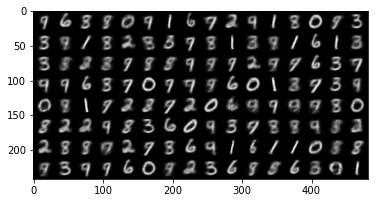

In [54]:
## Plots
xs, labels = iter(test_loader).next()
    
xs = xs.to(device)
recons = D(E(xs)).to("cpu")
#recons.shape
#grid_img = make_grid(xs.cpu(), nrow=16)
#plt.imshow(grid_img.permute(1,2,0))

grid_img = make_grid(recons, nrow=16)
plt.imshow(grid_img.permute(1,2,0))



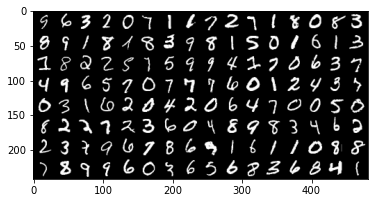

In [55]:
grid_img = make_grid(xs.cpu(), nrow=16)
plt.imshow(grid_img.permute(1,2,0))


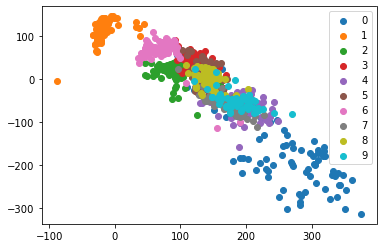

In [53]:
xs, labels = iter(test_loader).next()
for i in range(5):
    x, ls = iter(test_loader).next()
    xs = torch.cat((xs,x))
    labels = torch.cat((labels,ls))
z = E(xs.to(device))
xs = xs.cpu()
labels = labels.cpu()
labels = labels.detach().numpy()
z = z.cpu()
z = z.detach().numpy()
x = z[:,0]
y = z[:,1]
fig, ax = plt.subplots()
for i in range(10):
    ax.scatter(x[labels == i], y[labels == i], label=str(i))
#ax.scatter(x,y, c=labels, label=labels)
ax.legend()

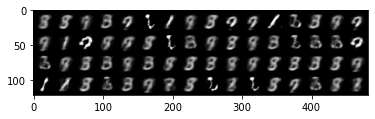

In [70]:
# Reconstruct images from random samples of the latent space 
sample = gmm.sample((64,)).to(device)
sample = D(sample)
sample = sample.cpu()
#xs.shape
#E(xs).shape
#sample = model.decode(sample).cpu()
#sample = sample.view(-1, 1, 28, 28)
#sample.shape
grid_img = make_grid(sample, nrow=16)
plt.imshow(grid_img.permute(1,2,0))


In [76]:
gmm.sample((100,))
#E(xs)

tensor([[ 5.4023,  4.7988],
        [ 2.9571,  4.6427],
        [ 8.7079,  8.6972],
        [ 1.6082,  0.7235],
        [ 4.1083,  2.6154],
        [ 6.5020,  5.2289],
        [ 6.9814,  5.9210],
        [ 7.2841,  4.2421],
        [ 5.4048,  4.3324],
        [ 7.2475,  4.3135],
        [ 4.3425,  4.2471],
        [ 0.7230,  2.0913],
        [ 4.1283,  2.1265],
        [ 0.0290, -0.3445],
        [ 5.6641,  5.4322],
        [ 2.9489,  3.2256],
        [ 0.0185,  0.3194],
        [-0.2720,  1.0534],
        [ 1.0851, -1.4186],
        [ 6.1511,  6.2560],
        [ 7.0238,  7.0622],
        [-1.5553, -0.2033],
        [ 6.3524,  6.5593],
        [10.0489,  9.5424],
        [ 7.3167,  5.4004],
        [ 7.8313,  8.4734],
        [ 8.1372,  6.6967],
        [ 6.2324,  5.3248],
        [ 6.5974,  6.5999],
        [ 3.6734,  4.4264],
        [-0.1401, -0.3247],
        [ 2.7023,  3.2260],
        [ 2.8478,  2.3434],
        [ 3.6431,  4.7807],
        [ 0.8251,  2.0553],
        [ 2.3868, -0

In [77]:
E(xs)

tensor([[ 1.6590e+02, -4.2007e+01],
        [ 5.1160e+01,  7.0044e+01],
        [ 1.2567e+02,  1.7711e+01],
        [ 1.4159e+02, -5.6611e+00],
        [ 2.7684e+02, -1.7449e+02],
        [ 1.7604e+02, -4.5131e+01],
        [-4.1212e+00,  1.3246e+02],
        [ 6.8469e+01,  6.6246e+01],
        [ 1.8384e+02, -8.9339e+01],
        [ 8.5443e+01,  2.5301e+01],
        [ 1.9046e+02, -4.4605e+01],
        [-4.0169e+00,  1.2295e+02],
        [ 1.4572e+02,  1.1909e+01],
        [ 3.1349e+02, -2.4312e+02],
        [ 1.3383e+02, -1.9437e+01],
        [ 1.2124e+02,  5.7081e+01],
        [ 1.2811e+02,  2.6158e+01],
        [ 1.7138e+02, -4.4408e+01],
        [-3.7236e+01,  1.2301e+02],
        [ 1.4715e+02,  1.6356e+01],
        [ 7.4731e+01,  1.1074e+01],
        [ 1.7335e+02,  1.2660e+01],
        [ 9.4878e+01,  5.4608e+01],
        [ 1.7368e+02, -5.7212e+01],
        [ 1.5087e+02,  8.8763e+00],
        [-7.1790e+00,  1.3516e+02],
        [ 1.5056e+02,  3.3059e+01],
        [ 1.8227e+02, -1.418